In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Verification of MINA routines against D717A weld from Moysan (2003)
This notebook compares the outputs of:
* `mina_weld` package
* David Fan's MATLAB implementation of MINA from NDE Lab repository
* the image from Moysan (2003).

### Missing data from Moysan (2003):
* the number of passes per layer; they may only be inferred from Fig 2., but this is prone to error.
* the height of the top parabola is also not given.


In [2]:
"""
A test validating mina-weld against Moysan et al. (2003), case D717A
Created by: Michal K. Kalkowski
20/02/2018

License: MIT
"""
import numpy as np
import matplotlib.pyplot as plt
import mina.mina_model as mina

# Create weld model
weld_parameters = dict([('remelt_h', 0.47),
                        ('remelt_v', 0.26),
                        ('theta_b', np.deg2rad(18)),
                        ('theta_c', np.deg2rad(12)),
                        ('order', 'left_to_right'),
                        ('number_of_layers', 11),
                        ('number_of_passes', np.array([1]*1 + 4*[2] + 2*[3] +
                                                      [4]*4)),
                        ('electrode_diameter', np.array([1.6, 2.5, 3.2, 4] +
                                                        [5]*4 + [4]*3)),
                        ('a', 38),
                        ('b', 4),
                        ('c', 36)])
weld = mina.MINA_weld(weld_parameters)
weld.define_grid_size(2., use_centroids=False)
weld.h_top = 0.2
weld.solve()
# weld.fill_missing()


------MINA model setup------
Horizontal remelting rate: 0.47
Vertical remelting rate: 0.26
theta_b and theta_c: 0.3141592653589793 and 0.20943951023931956
Order of passes: left_to_right
Number of layers: 11
Number of passes: [1 2 2 2 2 3 3 4 4 4 4]
Electrode diameter: [1.6 2.5 3.2 4.  5.  5.  5.  5.  4.  4.  4. ]
Weld thickness: 38
Chamfer base: 4
Chamfer top: 36
----------------------------


## Passes layout

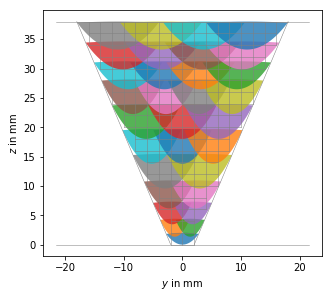

In [3]:
weld.plot_passes(grid=True)
# plt.plot(weld.point_o[:, 0], weld.point_o[:, 1], 'o')

## Final orientations: element centroid-based

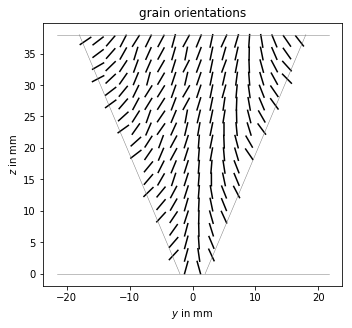

In [4]:
weld.define_grid_size(2., use_centroids=True)
weld.solve()
# weld.fill_missing()
weld.plot_grain_orientations(grid=False)

## Nodes based - 'missing' nodes filled with mean of orientations in surrounding elements.

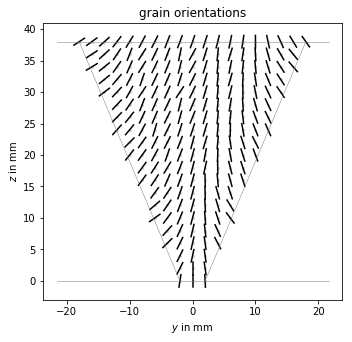

In [5]:
weld.define_grid_size(2., use_centroids=False)
weld.h_top = 0.2
weld.solve()
weld.fill_missing()
weld.plot_grain_orientations(grid=True)

In [6]:
%pwd

'/media/michal/MKK_data/mCloud/ADVISE_local/mina_weld/notebooks'

## David Fan's code

![](../references/D_Fan_MATLAB_prediction_Moysan_2003.png)

## Original - Moysan (2003)
![](../references/Moysan_2003.png)

## General observations:
* results are qualitatively similar, but differences occur. 
* overall my code is quite close to Moysan (2003), while David's appears to be in worse agreement.
* I am in favour of the element-centroid based calculation; the result does not change much but if feels somewhat more appropriate and coherent. Both DF and Moysan (2003) use a nodes based approach and take the outcome of seeding as MINA grid; `mina weld` takes the midpoints between seeds as MINA grid.
* I validated the key parameters of MINA model (layers, pass widths, pass centre coordinates etc.) with DF - they all agree.

## Potential reasons for discrepancies with David Fan's code:
* DF uses parallelopipeds to model a pass, not two parabolas as in Moysan (2003); the consequence is that some MINA grid points are assigned to different passes as compared to `mina_weld` and the original paper, with different thermal gradients, etc.
* inside the epitaxial growth loop - DF uses athe same `alpha_0` for all MINA grid points inside one pass. 
* in `mina_weld`, the lowest element adopts and keeps the thermal gradient calculated geometrically; the epitaxial growth loop is applied from layer two onwards (MINA grid layer, not layer of passes). Each MINA grid point takes the orientation of MINA grid point just below as `alpha_0`. This is also what [Moysan, J., Corneloup, G., Chassignole, B., Gueudré, C., Ploix, M.A., 2012. Modelling welded material for ultrasonic testing using MINA: Theory and applications. pp. 1219–1226. https://doi.org/10.1063/1.4716358] suggests.
* `mina_weld` requires some 'height' of the top parabola; otherwise, some MINA grid points will not be covered; DF does not use parabolas to determine parent pass, hence he does not need the top height. This problem was highlighted in Gueudre et al. (2009) and it seems that `mina_weld` follows the original, as similar issues are encountered. `mina_weld` addresses this problem by calculating the mean orientation of all neighbouring MINA elements and assigning this mean to the unassigned element.
* DF's code always assigns an inclination angle to a pass, whereas according to [Moysan, J., Corneloup, G., Chassignole, B., Gueudré, C., Ploix, M.A., 2012. Modelling welded material for ultrasonic testing using MINA: Theory and applications. pp. 1219–1226. https://doi.org/10.1063/1.4716358] it should be zero if a pass is deposited between two other passes or a pass and chamfer wall.

## Other issues:
* The original MINA paper has low reproducibility. Incomplete data for simulations is provided, and some inconsistences can be spotted. For example, the weld root is supposed to be 4 mm (Moysan, 2003). But, for a 2 mm grid, the figure from  Moysan (2003) indicates the weld root of 6 mm (four orientation lines are present). These issues are not possible to resolve.

## Final comment:
* The impact of MINA grid size is significant - finer grids lead to more pronounced differences between passes, which may be far from reality. Moysan (2003) states that a 2 mm grid is a compromise between the accurate representation of the variation of orientation and not going into modelling at the dendrite level. However, subsequent papers, including David Fan's use 0.5 mm grid (at least on paper - from graphs it appears more as 1 mm ...). Another point which is not clear. 
* Using DF's code which according to the above comments took different approaches from those proposed in the original MINA gives a reasonably smooth orientation map even for fine grids. On the other hand, my implementation of MINA, appearing to be closer to the original, shows large differences between neighbouring MINA grid elements, which may not be that physical (similar effects can be inferred from graphs in [Gueudre, C., Le Marrec, L., Moysan, J., Chassignole, B., 2009. Direct model optimisation for data inversion. Application to ultrasonic characterisation of heterogeneous welds. NDT & E International 42, 47–55. https://doi.org/10.1016/j.ndteint.2008.07.003].